# Model training - PCA
This file consist of model training and results of feature-reduction. The same reasoning from ModelTraining.ipynb applies here, so it's not duplicated. Full reasoning details can be seen in ModelTraining.ipynb.

In [1]:
from keras import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
import pandas as pd
import ImageLoader
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
images_dataframe = ImageLoader.load()
targets_dataframe = pd.read_csv("cleaned_fashion.csv", sep=';')
targets_dataframe.set_index("id", inplace=True)
classes = targets_dataframe.target.unique()
targets_numeric = np.arange(classes.size, dtype=int)
targets_dict = dict(zip(classes, targets_numeric))
targets_dataframe['target_numeric'] = [ targets_dict.get(target) for target in targets_dataframe.target ]

In [3]:
pca = PCA(n_components=480)

In [4]:
X = images_dataframe.values
X = pca.fit_transform(X)
y = targets_dataframe.target_numeric
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=120)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [5]:
classes = targets_dataframe.target.unique()
targets_numeric = np.arange(classes.size, dtype=int)
targets_dict = dict(zip(classes, targets_numeric))
targets_dataframe['target_numeric'] = [ targets_dict.get(target) for target in targets_dataframe.target ]
classes_num = classes.size

In [161]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='KeepWeights\\pca_reduced_dropout_best_model_2_layers_2_quarter_{epoch:02d}-{loss:.4f}-{val_loss:.2f}.keras.keras',  # File to save the model
    monitor='loss',        # Monitor validation loss
    save_best_only=False,       # Save only the best weights
    mode='min',                # We are minimizing the validation loss
    verbose=1
)

In [162]:
from keras.layers import Dropout
num_features = X.shape[1]
input_layer = Input( shape = (num_features,) )
hidden_layer_1 = Dense( num_features//2, activation='relu')(input_layer)
hidden_layer_last = Dense( num_features//4, activation='relu')(hidden_layer_1)
dropout_layer = Dropout(0.5)(hidden_layer_last)
output_layer = Dense(classes_num, activation='softmax')(dropout_layer)
mlp_class = Model(inputs=[input_layer], outputs=[output_layer])
mlp_class.compile(loss='categorical_crossentropy', optimizer='adam')

## Training

In [163]:
training_history = mlp_class.fit(X_train, y_train, epochs=100, 
                                 batch_size=100, validation_split=0.2, 
                                 verbose=2, callbacks=[checkpoint], 
                                 shuffle=True, )

Epoch 1/100


D:\Users\crash\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(



Epoch 1: saving model to KeepWeights\pca_reduced_dropout_best_model_2_layers_2_quarter_01-3.3151-0.41.keras.keras
231/231 - 2s - 7ms/step - loss: 3.3151 - val_loss: 0.4111
Epoch 2/100

Epoch 2: saving model to KeepWeights\pca_reduced_dropout_best_model_2_layers_2_quarter_02-0.8456-0.40.keras.keras
231/231 - 0s - 2ms/step - loss: 0.8456 - val_loss: 0.3967
Epoch 3/100

Epoch 3: saving model to KeepWeights\pca_reduced_dropout_best_model_2_layers_2_quarter_03-0.5366-0.25.keras.keras
231/231 - 0s - 2ms/step - loss: 0.5366 - val_loss: 0.2520
Epoch 4/100

Epoch 4: saving model to KeepWeights\pca_reduced_dropout_best_model_2_layers_2_quarter_04-0.3069-0.22.keras.keras
231/231 - 0s - 2ms/step - loss: 0.3069 - val_loss: 0.2158
Epoch 5/100

Epoch 5: saving model to KeepWeights\pca_reduced_dropout_best_model_2_layers_2_quarter_05-0.2717-0.21.keras.keras
231/231 - 0s - 2ms/step - loss: 0.2717 - val_loss: 0.2090
Epoch 6/100

Epoch 6: saving model to KeepWeights\pca_reduced_dropout_best_model_2_laye

## After Training

### functions declaration

In [184]:
import matplotlib.pyplot as plt
def plot_classification(y_pred, y_true, model_name):
    # Create the figure and 1x3 grid for subplots
    plt.figure(figsize=(20, 5))
    
    correct_ids = np.where(y_true == y_pred)[0]
    incorrect_ids = np.where(y_true != y_pred)[0]
    
    # Subplot 1: Correct classifications
    plt.ylim(-0.5, 7.5)
    plt.scatter(range(len(y_pred[correct_ids])), y_pred[correct_ids], marker='o', s=2, c=y_true[correct_ids])
    plt.xlabel('Test Samples')
    plt.ylabel('Predicted Classes')
    plt.title(f'Correct classification via {model_name}')
    plt.show()

    plt.figure(figsize=(20, 5))
    # Subplot 2: Incorrect classifications
    plt.subplot(1, 2, 1)  # 1 row, 3 columns, second subplot
    plt.ylim(-0.5, 7.5)
    plt.scatter(range(len(y_pred[incorrect_ids])), y_pred[incorrect_ids], marker='o', s=8, c=y_true[incorrect_ids])
    plt.title(f'Incorrect classification via {model_name}')
    plt.tight_layout()
    
    # Subplot 3: Correct values for incorrect classifications
    plt.subplot(1, 2, 2)  # 1 row, 3 columns, third subplot
    plt.ylim(-0.5, 7.5)
    plt.scatter(range(len(y_true[incorrect_ids])), y_true[incorrect_ids], marker='o', s=8, c=y_true[incorrect_ids])
    plt.title(f'Correct value for incorrect classification via {model_name}')
    plt.tight_layout()
    
    plt.show()
    print(f'Incorrectly classified {len(y_pred[incorrect_ids])} samples out of {len(y_true)}')

import pickle
def training_plot(filename):
    with open(filename, "rb") as file:
        loaded_history = pickle.load(file)
    
    # summarize history for loss
    plt.plot(loaded_history.get('loss'))
    plt.plot(loaded_history.get('val_loss'))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show() 

### Loading

In [164]:
import pickle

# Save history
with open("training_history_pca_reduced_dropout_best_model_2_layers_2_quarter.pkl", "wb") as file:
    pickle.dump(training_history.history, file)

In [165]:
mlp_class.load_weights('KeepWeights\\pca_reduced_dropout_best_model_2_layers_2_quarter_47-0.0411-0.16.keras.keras')

### Following model is the best I managed to get. 96.80%

In [166]:
y_pred = mlp_class.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_classes == y_test_classes) * 100
print(f"Accuracy: {accuracy:.2f}%")

199/386 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step

D:\Users\crash\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(


386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
Accuracy: 96.80%


In [170]:
mlp_class.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 240)            │       115,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 120)            │        28,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           968 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,986 (1.66 MB)

 Trainable params: 145,328 (567.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 290,658 (1.11 MB)

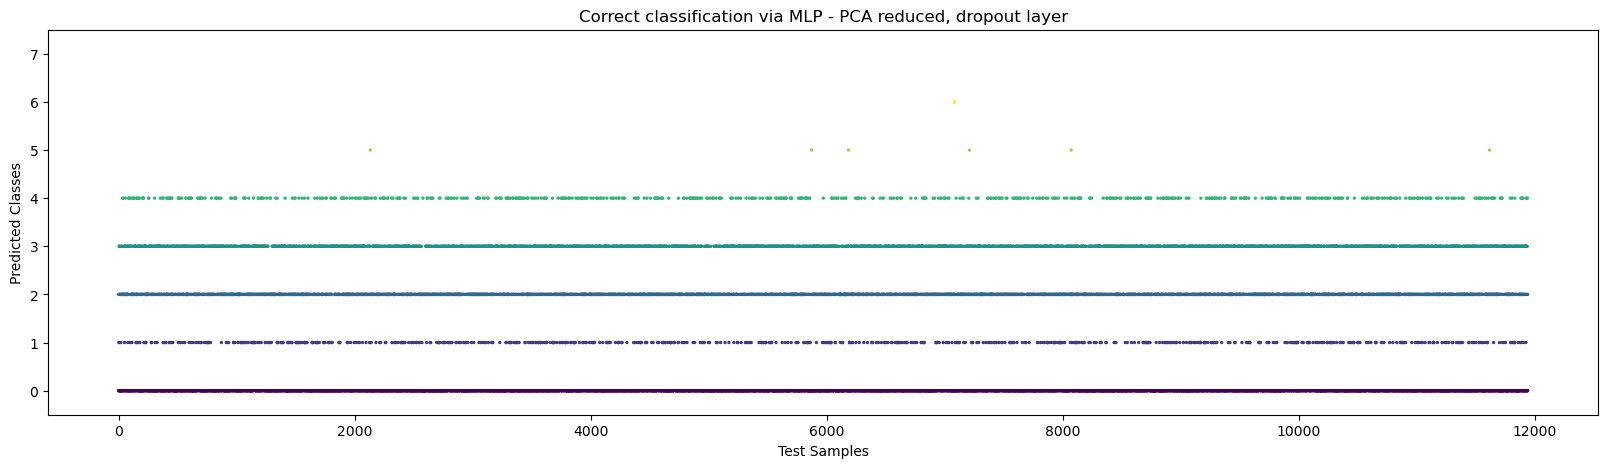

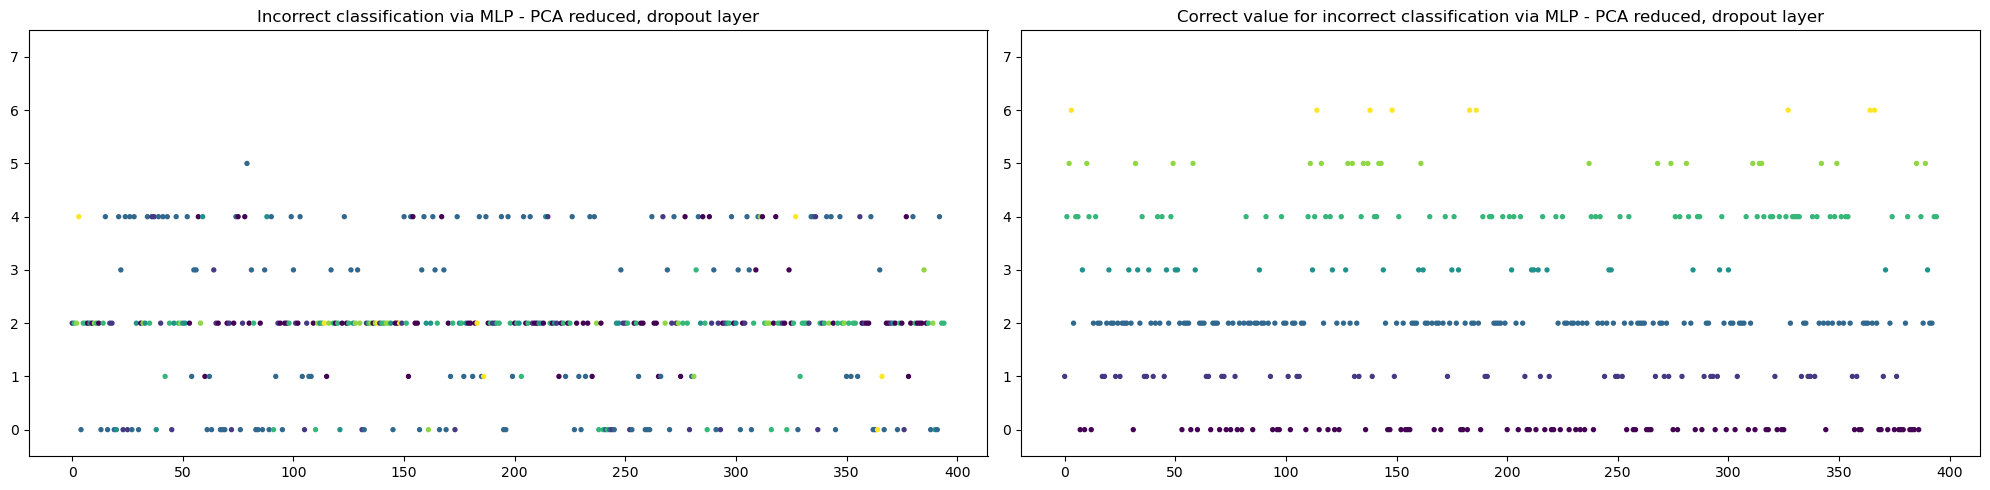

Incorrectly classified 395 samples out of 12337


In [185]:
plot_classification(y_pred_classes, y_test_classes, "MLP - PCA reduced, dropout layer")

We can see model's overfitting on this plot:

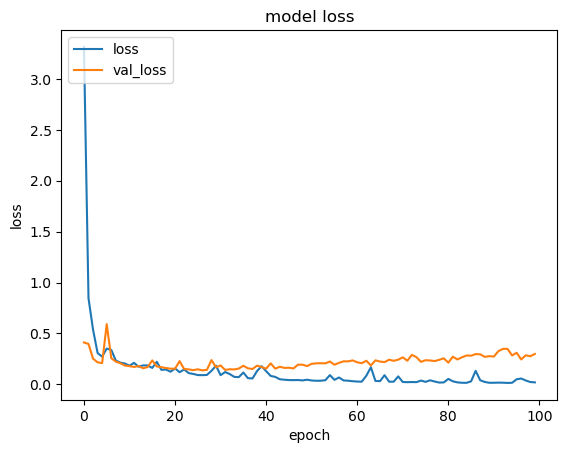

In [169]:
training_plot("training_history_pca_reduced_dropout_best_model_2_layers_2_quarter.pkl")

# Summary

Models with reduced features perform better than models with all the features. PCA's feature reduction increased accuracy by around 3%. In my understanding, it's because of reducing the bad pixels that bring noise to the model (like background pixels) which were hurting classification performance before.

Additionally model is now more capable of classifying samples to class number 5 and 6.    
I tested the feature-reduced model with corresponding layer numbers and neuron numbers:
- 2 layers, 1st 1/2, 2nd 1/8 of feature number
- 2 layers, 1st 1/2, 2nd 1/4 of feature number *
- 2 layers, 1st 1/2, 2nd 1/2 of feature number
- 2 layers, 1st 1/2, 2nd 1/8 of feature number
- 3 layers, 1st 1/2, 2nd 1/4, 3rd 1/4 of feature number

These models are saved in keras files. I'm not adding them here for project clarity. Results were very simillar +/- 1%. One of the best models is loaded in this file: 1st layer half, 2nd quarter of features number. 